In [1]:
import numpy as np
import pandas as pd



In [27]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [4]:
from sqlalchemy import create_engine

nyc_database = create_engine('sqlite:///nyc_database.db')

In [10]:
df = pd.read_csv("./data/2019/yellow_tripdata_2019-01.csv", nrows=10)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [13]:
j, chunksize = 1, 100000
for month in range(1, 7):
    fp = './data/2019/yellow_tripdata_2019-{0:0=2d}.csv'.format(month)
    for df in pd.read_csv(fp, chunksize=chunksize, iterator=True):
        df['pickup_hour'] = [x[11:13] for x in df['tpep_pickup_datetime']]
        df['dropoff_hour'] = [x[11:13] for x in df['tpep_dropoff_datetime']]
        df.index += j
        df.to_sql('table_record', nyc_database, if_exists='append')
        j = df.index[-1] + 1
del df

In [6]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])


sf = shapefile.Reader("./data/2019/taxi_zones/taxi_zones.shp")
field_names = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(field_names, list(range(len(field_names)))))
attributes = sf.records()
shp_attr = [dict(zip(field_names, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


In [16]:
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [14]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [15]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

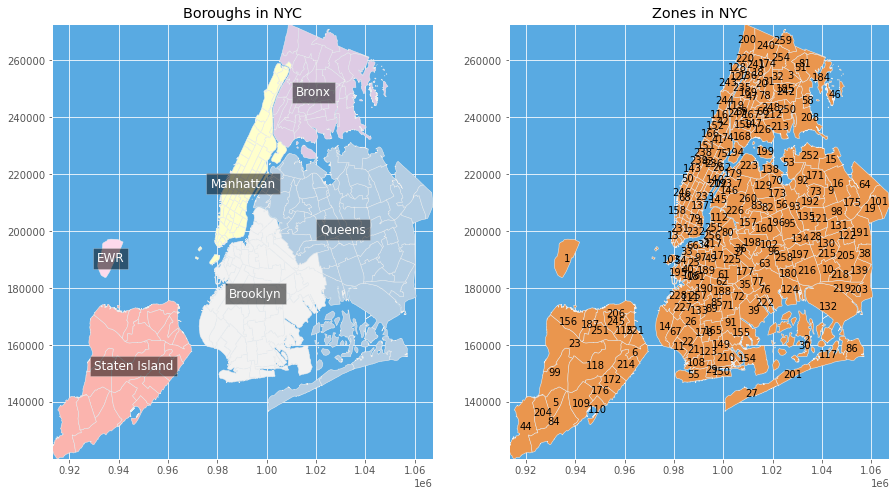

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

In [8]:
df_pu_lgd = pd.read_sql_query("SELECT PULocationID AS LocationID, count(*) AS PUCount \
                                FROM table_record \
                                WHERE DOLocationID = 138 \
                                GROUP BY PULocationID", nyc_database)


In [9]:
df_do_lgd = pd.read_sql_query("SELECT DOLocationID AS LocationID, count(*) AS DOCount \
                                FROM table_record \
                                WHERE PULocationID = 138 \
                                GROUP BY DOLocationID", nyc_database)

In [39]:
df_do_lgd.head()

,LocationID,DOCount
0,1,753
1,2,3
2,3,408
3,4,2535
4,5,4


In [40]:
df_pu_lgd.head()

,LocationID,PUCount
0,1,10
1,2,1
2,3,3
3,4,243
4,7,789


#### Zones with most pickups and dropoffs

In [10]:
template = pd.DataFrame([x for x in range(1, max(df_loc['LocationID'].tolist()))],
                       columns=['LocationID'])

df_q1 = pd.concat([df_pu_lgd, df_do_lgd]).join(template.set_index("LocationID"),
                                              how='outer',
                                              on=['LocationID']).fillna(0) \
                                            .groupby(['LocationID']) \
                                            .agg({'PUCount': 'sum', 'DOCount':'sum'}) \
                                            .sort_values(by=['LocationID'])

df_q1['TOTALcount'] = df_q1['PUCount'] + df_q1['DOCount']
loc = df_loc[["LocationID", "zone", "borough"]]
df_q1 = df_q1.merge(loc, left_on="LocationID", right_on="LocationID")


PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUCount'].tolist()))
PUtop20 = df_q1.sort_values(by=['PUCount'], ascending=False).set_index("LocationID")
DOcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['DOCount'].tolist()))
DOtop20 = df_q1.sort_values(by=['DOCount'], ascending=False).set_index("LocationID")


In [11]:
PUtop20

,PUCount,DOCount,TOTALcount,zone,borough
LocationID,,,,,
230,46004.0,66113.0,112117.0,Times Sq/Theatre District,Manhattan
161,40237.0,50265.0,90502.0,Midtown Center,Manhattan
162,33302.0,49030.0,82332.0,Midtown East,Manhattan
163,24722.0,29526.0,54248.0,Midtown North,Manhattan
170,19189.0,32516.0,51705.0,Murray Hill,Manhattan
...,...,...,...,...,...
31,0.0,105.0,105.0,Bronx Park,Bronx
30,0.0,11.0,11.0,Broad Channel,Queens
206,0.0,46.0,46.0,Saint George/New Brighton,Staten Island


In [18]:
DOtop20[DOtop20['TOTALcount'] > 0]

,PUCount,DOCount,TOTALcount,zone,borough
LocationID,,,,,
230,46004.0,66113.0,112117.0,Times Sq/Theatre District,Manhattan
161,40237.0,50265.0,90502.0,Midtown Center,Manhattan
162,33302.0,49030.0,82332.0,Midtown East,Manhattan
164,16686.0,32981.0,49667.0,Midtown South,Manhattan
170,19189.0,32516.0,51705.0,Murray Hill,Manhattan
...,...,...,...,...,...
204,0.0,8.0,8.0,Rossville/Woodrow,Staten Island
5,0.0,4.0,4.0,Arden Heights,Staten Island
2,1.0,3.0,4.0,Jamaica Bay,Queens


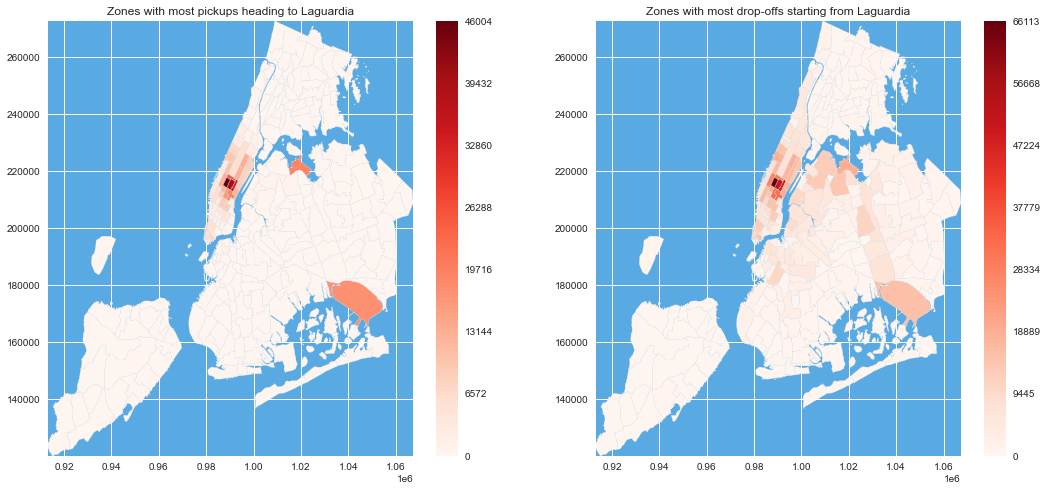

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups heading to Laguardia")
draw_zone_map(ax, sf, heat=PUcount, text=[''])
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs starting from Laguardia")
draw_zone_map(ax, sf, heat=DOcount, text=[''])

In [21]:
df_month = pd.read_sql_query('Select tpep_pickup_datetime as Month from table_record', nyc_database)


In [23]:
df_month['Month']= pd.to_datetime(df_month['Month']).dt.month

In [24]:
df_month.head()

,Month
0,1
1,1
2,12
3,11
4,11


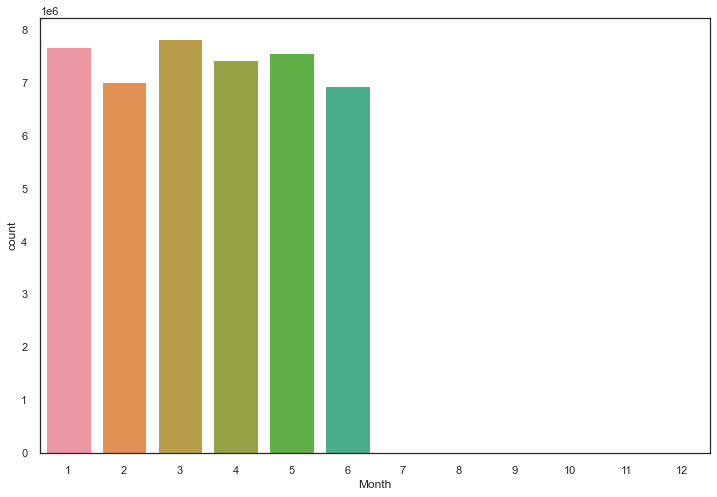

In [30]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.set_theme(style="white")
sns.countplot(x="Month", data=df_month)
plt.show()